In [20]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

In [49]:
with open('ego-twitter/out.ego-twitter','r') as f:
    edges=[x.strip().split('\t') for x in f.readlines()[2:]]

edges


[['1', '2'],
 ['1', '3'],
 ['1', '4'],
 ['1', '5'],
 ['1', '6'],
 ['1', '7'],
 ['1', '8'],
 ['1', '9'],
 ['1', '10'],
 ['1', '11'],
 ['1', '12'],
 ['1', '13'],
 ['1', '14'],
 ['1', '15'],
 ['1', '16'],
 ['1', '17'],
 ['1', '18'],
 ['1', '19'],
 ['1', '20'],
 ['1', '21'],
 ['1', '22'],
 ['1', '23'],
 ['1', '24'],
 ['1', '25'],
 ['1', '26'],
 ['1', '27'],
 ['1', '28'],
 ['1', '29'],
 ['1', '30'],
 ['1', '31'],
 ['1', '32'],
 ['1', '33'],
 ['1', '34'],
 ['1', '35'],
 ['1', '36'],
 ['1', '37'],
 ['1', '38'],
 ['1', '39'],
 ['1', '40'],
 ['1', '41'],
 ['1', '42'],
 ['1', '43'],
 ['1', '44'],
 ['1', '45'],
 ['1', '46'],
 ['1', '47'],
 ['1', '48'],
 ['1', '49'],
 ['50', '51'],
 ['50', '52'],
 ['50', '53'],
 ['50', '54'],
 ['50', '55'],
 ['50', '56'],
 ['50', '57'],
 ['50', '58'],
 ['50', '59'],
 ['50', '60'],
 ['50', '61'],
 ['50', '62'],
 ['63', '64'],
 ['63', '65'],
 ['63', '66'],
 ['63', '67'],
 ['63', '68'],
 ['63', '69'],
 ['63', '70'],
 ['63', '71'],
 ['63', '72'],
 ['63', '73'],
 ['63'

In [52]:
df = pd.DataFrame(
    edges,columns=['source','target']
)
df

,source,target
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
33096,10982,23366
33097,10982,23367
33098,10982,23368
33099,10982,23369


In [78]:
graph = StellarGraph(edges=df)

In [79]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 33101

 Node types:
  default: [23370]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [33101]
        Weights: all 1 (default)
        Features: none


In [80]:

edge_splitter_test = EdgeSplitter(graph)


graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)


** Sampled 3310 positive and 3310 negative edges. **


In [81]:
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 29791

 Node types:
  default: [23370]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [29791]
        Weights: all 1 (default)
        Features: none


In [82]:

edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)


** Sampled 2979 positive and 2979 negative edges. **


In [83]:
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

StellarGraph: Undirected multigraph
 Nodes: 23370, Edges: 26812

 Node types:
  default: [23370]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [26812]
        Weights: all 1 (default)
        Features: none


In [84]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,4468,Train Graph,Test Graph,Train the Link Classifier
Model Selection,1490,Train Graph,Test Graph,Select the best Link Classifier model
Test set,6620,Test Graph,Full Graph,Evaluate the best Link Classifier


In [85]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()

In [86]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [87]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 233700


In [88]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", max_iter=max_iter)
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_accuracy(clf,link_features_test, link_labels_test)
    return score


def evaluate_accuracy(clf, link_features, link_labels):
    pred_labels = clf.predict(link_features)
    acc_score=accuracy_score(link_labels,pred_labels)
    return acc_score

In [89]:
def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_l1, operator_l2, operator_avg]

In [91]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ACCURACY score"),
).set_index("name")

Best result from 'operator_l1'


,ACCURACY score
name,
operator_l1,0.806711
operator_l2,0.806040
operator_avg,0.753020


In [92]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 233700


In [94]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ACCURACY score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ACCURACY score on test set using 'operator_l1': 0.8202416918429003


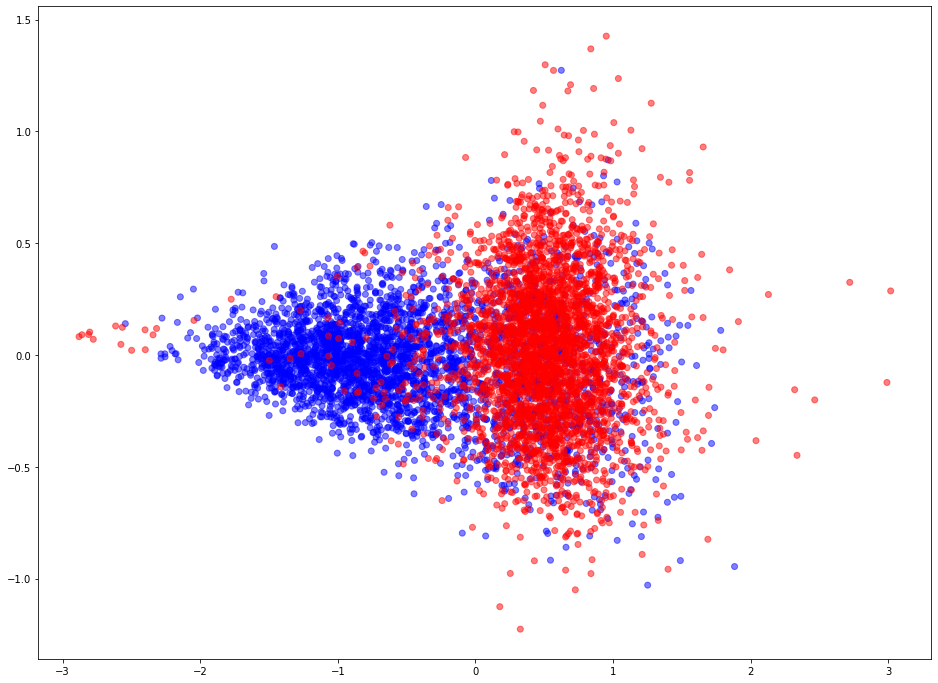

In [95]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)